In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hipofizdata/hipofizdicomjpeg/0/yıldızduy-0014.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/arzu-0012.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/kezbanyı-0003.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/sultantalıbal-0006.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/ayşesarı-0001.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/minepek-0005.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/MÜCELLADERVİŞOĞULLARI-0012.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/nejlac-0009.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/nejlac-0007.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/alinazl-0004.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/menekşeatak-0011.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/yurdusev-0001.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/menekşeatak-0005.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/nergizünlü-0001.jpg
/kaggle/input/hipofizdata/hipofizdicomjpeg/0/menekşeatak-0004.jpg
/kaggle/input/hipofizdata/hipofizdi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import shutil 
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# GPU kullanılabilirliğini kontrol et
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Kullanılacak cihaz: {device}")

# Matplotlib ayarları
plt.ion() # interactive mode

Kullanılacak cihaz: cuda:0


In [3]:
data_dir = "/kaggle/input/hipofizdata/hipofizdicomjpeg"

# Veri yolunun varlığını ve içeriğini kontrol et
if not os.path.exists(data_dir):
    print(f"HATA: Veri yolu bulunamadı: {data_dir}")
    print("Lütfen Kaggle veri setinizin doğru şekilde eklendiğinden ve yolun doğru olduğundan emin olun.")
    print("\nKullanılabilir dosyalar /kaggle/input/ altında:")
    # /kaggle/input altındaki tüm dosya ve klasörleri listelemek için:
    for dirname, _, filenames in os.walk('/kaggle/input'):

        if dirname.count(os.sep) < 3: # Örnek olarak derinliği sınırlar
             print(f"Dizin: {dirname}")
             for filename in filenames[:5]: # Her dizinden en fazla 5 dosya göster
                 print(f"  Dosya: {os.path.join(dirname, filename)}")
    raise FileNotFoundError(f"Veri yolu {data_dir} konumunda bulunamadı.")
elif not (os.path.exists(os.path.join(data_dir, "0")) and os.path.exists(os.path.join(data_dir, "1"))):
    print(f"HATA: Beklenen '0' ve '1' sınıf klasörleri '{data_dir}' içinde bulunamadı.")
    print(f"'{data_dir}' içeriği:")
    for item in os.listdir(data_dir):
        print(f"  - {item}")
    raise FileNotFoundError(f"Sınıf klasörleri ('0', '1') {data_dir} içinde bulunamadı.")
else:
    print(f"Veri seti ana yolu başarıyla ayarlandı: {data_dir}")
    print("Bulunan sınıf klasörleri (veya dosyalar):", os.listdir(data_dir))

Veri seti ana yolu başarıyla ayarlandı: /kaggle/input/hipofizdata/hipofizdicomjpeg
Bulunan sınıf klasörleri (veya dosyalar): ['0', '1']


Veri yükleniyor: /kaggle/input/hipofizdata/hipofizdicomjpeg
Sınıflar: ['0', '1']
Toplam 617 görüntü bulundu.
Hedeflenen boyutlar - Eğitim: 431, Doğrulama: 92, Test: 94
Gerçekleşen boyutlar - Eğitim: 431, Doğrulama: 92, Test: 94
DataLoader boyutları - Eğitim: 431, Doğrulama: 92, Test: 94


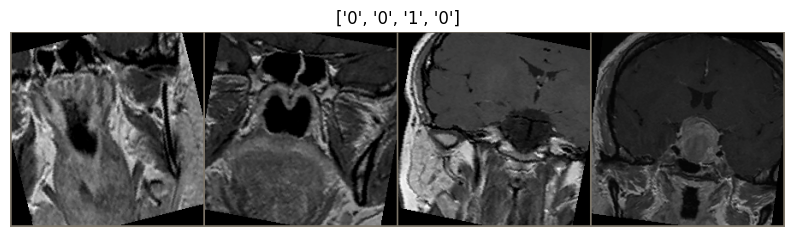

In [4]:
# MobileNetV3 için beklenen giriş boyutu genellikle 224x224'tür
input_size = 224
batch_size = 32 # GPU belleğinize göre ayarlayabilirsiniz

# Görüntü dönüşümleri
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Renk oynamaları
        transforms.RandomRotation(15), # Rastgele döndürme
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet istatistikleri
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size + 32), # Genellikle 256 yapılır, sonra center crop
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Test seti için de val ile aynı transformlar kullanılır
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# ImageFolder ile tüm veri setini yükle
# Başlangıçta tüm veri setine 'train' transformunu uygulayabiliriz,


print(f"Veri yükleniyor: {data_dir}")
full_dataset_raw = datasets.ImageFolder(data_dir) # Henüz transform uygulanmadı
class_names = full_dataset_raw.classes
num_classes = len(class_names)
total_images = len(full_dataset_raw)

print(f"Sınıflar: {class_names}")
print(f"Toplam {total_images} görüntü bulundu.")

# Veri setini eğitim, doğrulama ve test olarak ayır
# Oranlar: %70 Eğitim, %15 Doğrulama, %15 Test
train_ratio = 0.70
val_ratio = 0.15
# test_ratio = 0.15 (kalanı)

train_size = int(train_ratio * total_images)
val_size = int(val_ratio * total_images)
test_size = total_images - train_size - val_size # Kalan tüm veriler test için

print(f"Hedeflenen boyutlar - Eğitim: {train_size}, Doğrulama: {val_size}, Test: {test_size}")

# random_split ile bölme
# random_split, orijinal dataset'e referans tutan Subset nesneleri döndürür.
# Bu Subset'lerin 'dataset' attribute'u üzerinden orijinal dataset'in transform'unu değiştirebiliriz.
# VEYA her bir Subset için ayrı bir transform ile DataLoader oluşturabiliriz (daha temiz olabilir).

train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(
    full_dataset_raw, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # Tekrarlanabilirlik için sabit seed
)

print(f"Gerçekleşen boyutlar - Eğitim: {len(train_dataset_raw)}, Doğrulama: {len(val_dataset_raw)}, Test: {len(test_dataset_raw)}")




# her bir subset için kendi transformunu saklayan özel bir dataset oluşturabiliriz.
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset_raw, transform=data_transforms['train'])
val_dataset = TransformedSubset(val_dataset_raw, transform=data_transforms['val'])
test_dataset = TransformedSubset(test_dataset_raw, transform=data_transforms['test'])


# DataLoader'ları oluştur
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"DataLoader boyutları - Eğitim: {dataset_sizes['train']}, Doğrulama: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")


# Birkaç örnek görüntü gösterelim (opsiyonel, ama hata ayıklama için iyi)
def imshow(inp, title=None):
    """Tensor için Imshow."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off') # Eksenleri kapat
    # plt.pause(0.001) # Colab'da bu sorun çıkarabilir, plt.show() daha iyi

# Eğitim verisinden bir batch al
try:
    inputs, classes = next(iter(dataloaders['train']))

    # Bu batch'ten bir grid yap ve göster
    out = torchvision.utils.make_grid(inputs[:4]) # İlk 4 resmi göster
    
    plt.figure(figsize=(10,4)) # Figür boyutunu ayarla
    imshow(out, title=[class_names[x] for x in classes[:4]])
    plt.show()
except Exception as e:
    print(f"Örnek görüntüler gösterilirken hata: {e}")
    print("Veri yükleyicilerinde veya transformlarda bir sorun olabilir.")

In [5]:
try:
    model_ft = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    print("MobileNetV3 Small, yeni 'weights' API'si ile yüklendi.")
except TypeError:
    model_ft = models.mobilenet_v3_small(pretrained=True)
    print("MobileNetV3 Small, eski 'pretrained=True' API'si ile yüklendi.")


# Modelin son sınıflandırıcı katmanını al
# MobileNetV3'te bu genellikle model.classifier'dır
num_ftrs = model_ft.classifier[-1].in_features # Son lineer katmanın giriş özellik sayısı

# Yeni sınıflandırıcı katmanını (num_classes) göre ayarla
model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)

# Modeli GPU'ya taşı (eğer varsa)
model_ft = model_ft.to(device)

print(f"\nModel {num_classes} sınıf için ayarlandı.")
print("Model yapısının son kısmı (sınıflandırıcı):")
print(model_ft.classifier)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 46.9MB/s]


MobileNetV3 Small, yeni 'weights' API'si ile yüklendi.

Model 2 sınıf için ayarlandı.
Model yapısının son kısmı (sınıflandırıcı):
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()


# Farklı katmanlar için farklı öğrenme oranları da ayarlanabilir, ama başlangıç için bu yeterli.
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001) # Adam optimizatörü

# Öğrenme oranını her N epoch'ta bir gama ile çarp (opsiyonel ama faydalı)
# Örneğin, her 7 epoch'ta bir öğrenme oranını 0.1 ile çarp
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_loss = float('inf') # En iyi doğrulama kaybını takip et (erken durdurma için)
    
    epochs_no_improve = 0 # Erken durdurma için sayaç

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Her epoch'un bir eğitim ve bir doğrulama fazı vardır
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modeli eğitim moduna al
            else:
                model.eval()   # Modeli değerlendirme moduna al

            running_loss = 0.0
            running_corrects = 0

            # Veri üzerinde yinele
            current_dataloader = dataloaders[phase]
            current_dataset_size = dataset_sizes[phase]

            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Parametre gradyanlarını sıfırla
                optimizer.zero_grad()

                # İleri geçiş
                # Sadece eğitim fazında gradyanları izle
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Sadece eğitim fazında geri geçiş + optimize et
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # İstatistikler
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step() # Öğrenme oranını güncelle (her epoch sonunda)

            epoch_loss = running_loss / current_dataset_size
            epoch_acc = running_corrects.double() / current_dataset_size

            print(f'{phase.capitalize()} Kayıp: {epoch_loss:.4f} Doğruluk: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else: # phase == 'val'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # En iyi modeli doğruluk ve kayıp bazında kaydet
                if epoch_acc > best_acc: # En iyi doğruluğa göre kaydet
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'Yeni en iyi doğrulama doğruluğu: {best_acc:.4f}')
                    epochs_no_improve = 0 # İyileşme oldu, sayacı sıfırla
                #else: # Sadece kayba göre erken durdurma için
                #    epochs_no_improve +=1

                # Erken durdurma için kayba göre kontrol (opsiyonel)
                if epoch_loss < best_val_loss:
                     best_val_loss = epoch_loss
                     if epoch_acc >= best_acc - 0.01: # Doğruluk çok düşmediyse modeli kaydet
                         best_model_wts = copy.deepcopy(model.state_dict()) # Kayba göre de kaydedebiliriz
                         print(f'Yeni en iyi doğrulama kaybı: {best_val_loss:.4f} (Doğruluk: {epoch_acc:.4f})')
                     epochs_no_improve = 0
                else:
                     epochs_no_improve +=1


        print()
        
        # Erken durdurma kontrolü
        if epochs_no_improve >= patience:
            print(f'{patience} epoch boyunca doğrulama kaybında iyileşme olmadı. Eğitim durduruluyor.')
            break


    time_elapsed = time.time() - since
    print(f'Eğitim {time_elapsed // 60:.0f}d {time_elapsed % 60:.0f}s içinde tamamlandı')
    print(f'En iyi doğrulama Doğruluğu: {best_acc:4f}')

    # En iyi model ağırlıklarını yükle
    model.load_state_dict(best_model_wts)
    return model, history

In [7]:
# Eğitim için epoch sayısı ve erken durdurma kriteri
num_epochs_to_train = 25 
early_stopping_patience = 7 # Doğrulama kaybı bu kadar epoch iyileşmezse dur

# Modeli eğit
model_trained, training_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                              num_epochs=num_epochs_to_train,
                                              patience=early_stopping_patience)

Epoch 1/25
----------
Train Kayıp: 0.6913 Doğruluk: 0.5824
Val Kayıp: 0.9249 Doğruluk: 0.6196
Yeni en iyi doğrulama doğruluğu: 0.6196
Yeni en iyi doğrulama kaybı: 0.9249 (Doğruluk: 0.6196)

Epoch 2/25
----------
Train Kayıp: 0.5876 Doğruluk: 0.6682
Val Kayıp: 1.1668 Doğruluk: 0.6196

Epoch 3/25
----------
Train Kayıp: 0.5538 Doğruluk: 0.7309
Val Kayıp: 0.5762 Doğruluk: 0.6957
Yeni en iyi doğrulama doğruluğu: 0.6957
Yeni en iyi doğrulama kaybı: 0.5762 (Doğruluk: 0.6957)

Epoch 4/25
----------
Train Kayıp: 0.5236 Doğruluk: 0.7285
Val Kayıp: 0.9583 Doğruluk: 0.6304

Epoch 5/25
----------
Train Kayıp: 0.4945 Doğruluk: 0.7471
Val Kayıp: 1.8332 Doğruluk: 0.6196

Epoch 6/25
----------
Train Kayıp: 0.4695 Doğruluk: 0.7657
Val Kayıp: 0.9099 Doğruluk: 0.6739

Epoch 7/25
----------
Train Kayıp: 0.4240 Doğruluk: 0.7819
Val Kayıp: 0.9613 Doğruluk: 0.6630

Epoch 8/25
----------
Train Kayıp: 0.3473 Doğruluk: 0.8260
Val Kayıp: 0.7689 Doğruluk: 0.7283
Yeni en iyi doğrulama doğruluğu: 0.7283

Epoch 9/25

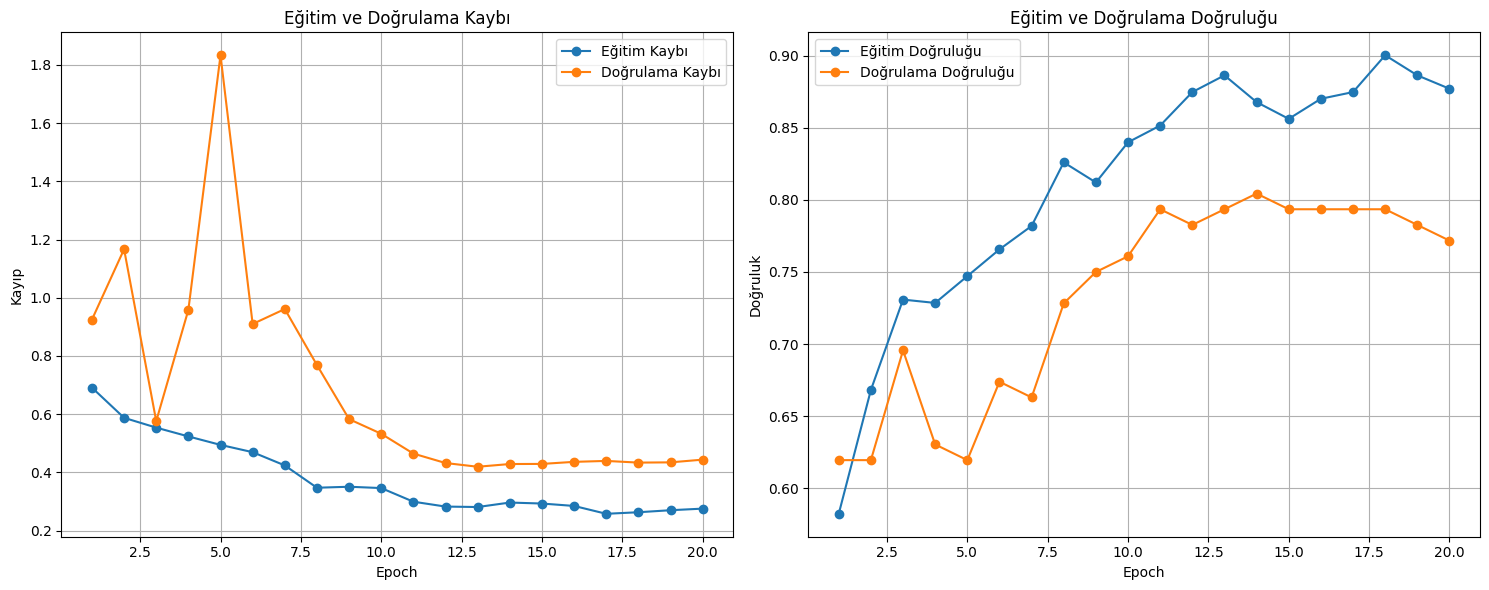

In [8]:
# Eğitim geçmişinden verileri al
train_losses = training_history['train_loss']
val_losses = training_history['val_loss']
train_accs = training_history['train_acc']
val_accs = training_history['val_acc']

# Kaç epoch tamamlandığını belirle (erken durdurma varsa num_epochs_to_train'den az olabilir)
actual_epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(actual_epochs, train_losses, label='Eğitim Kaybı', marker='o')
plt.plot(actual_epochs, val_losses, label='Doğrulama Kaybı', marker='o')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(actual_epochs, train_accs, label='Eğitim Doğruluğu', marker='o')
plt.plot(actual_epochs, val_accs, label='Doğrulama Doğruluğu', marker='o')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Doğrulama Seti Değerlendirme Sonuçları ---


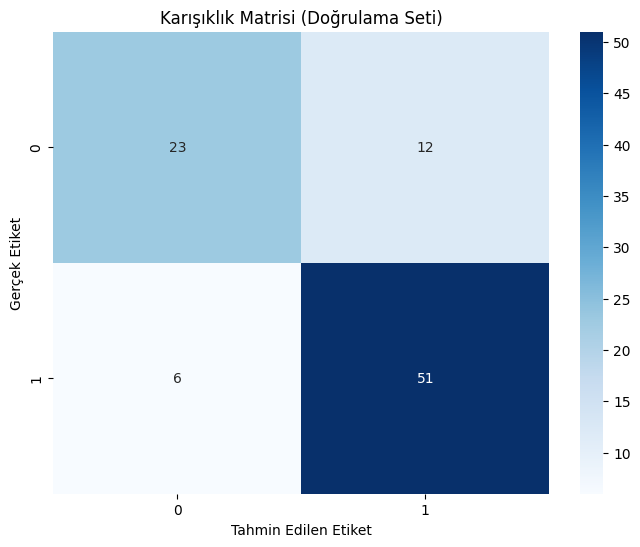


Sınıflandırma Raporu (Doğrulama Seti):

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        35
           1       0.81      0.89      0.85        57

    accuracy                           0.80        92
   macro avg       0.80      0.78      0.78        92
weighted avg       0.80      0.80      0.80        92

Genel Doğruluk (Doğrulama Seti): 0.8043


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np # np.array için

def evaluate_model_performance(model, dataloader, device, class_names_list, phase_name="Doğrulama"):
    model.eval()  # Değerlendirme modu
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Gradyan hesaplamasını kapat
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    y_true_np = np.array(all_labels)
    y_pred_np = np.array(all_preds)

    print(f"\n--- {phase_name} Seti Değerlendirme Sonuçları ---")
    
    # Karışıklık Matrisi
    cm = confusion_matrix(y_true_np, y_pred_np)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.xlabel('Tahmin Edilen Etiket')
    plt.ylabel('Gerçek Etiket')
    plt.title(f'Karışıklık Matrisi ({phase_name} Seti)')
    plt.show()

    # Sınıflandırma Raporu
    print(f"\nSınıflandırma Raporu ({phase_name} Seti):\n")
    print(classification_report(y_true_np, y_pred_np, target_names=class_names_list, zero_division=0))
    
    # Genel Doğruluk
    accuracy = np.sum(y_pred_np == y_true_np) / len(y_true_np)
    print(f"Genel Doğruluk ({phase_name} Seti): {accuracy:.4f}")

# Doğrulama seti üzerinde değerlendirme
evaluate_model_performance(model_trained, dataloaders['val'], device, class_names, phase_name="Doğrulama")


MODELİN TEST SETİ ÜZERİNDEKİ PERFORMANSI

--- Test Seti Değerlendirme Sonuçları ---


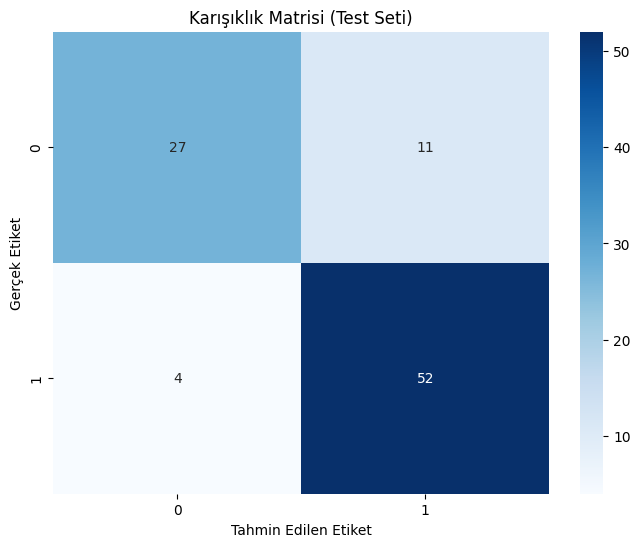


Sınıflandırma Raporu (Test Seti):

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.83      0.93      0.87        56

    accuracy                           0.84        94
   macro avg       0.85      0.82      0.83        94
weighted avg       0.84      0.84      0.84        94

Genel Doğruluk (Test Seti): 0.8404


In [10]:
# Test seti üzerinde değerlendirme
# evaluate_model_performance fonksiyonu aynı şekilde kullanılabilir.
print("\n" + "="*50)
print("MODELİN TEST SETİ ÜZERİNDEKİ PERFORMANSI")
print("="*50)
evaluate_model_performance(model_trained, dataloaders['test'], device, class_names, phase_name="Test")


Doğrulama Setinden Örnek Tahminler:


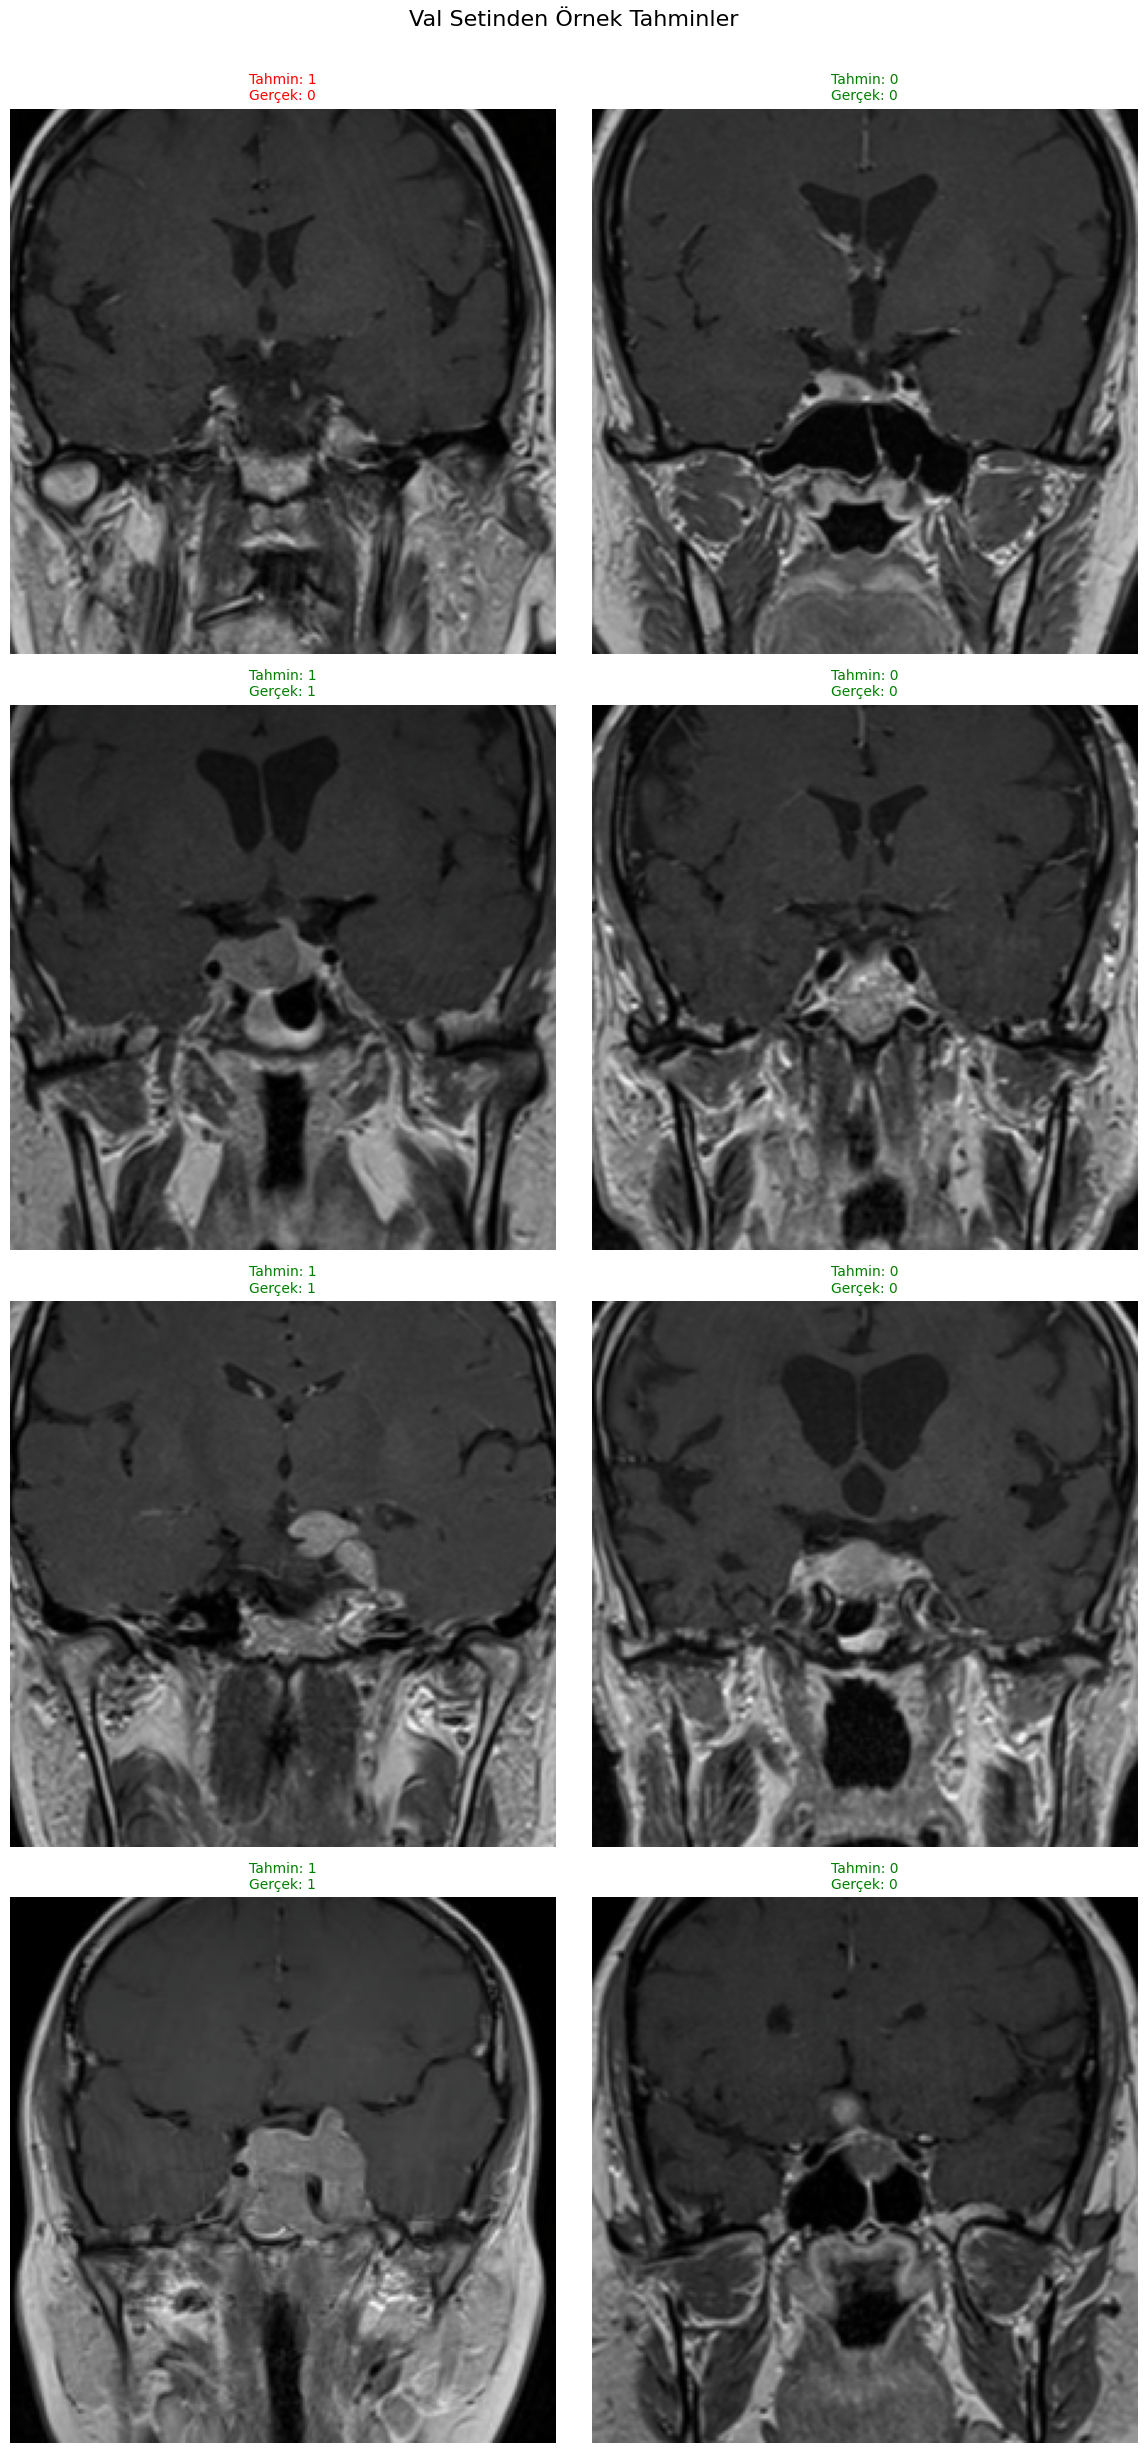


Test Setinden Örnek Tahminler:


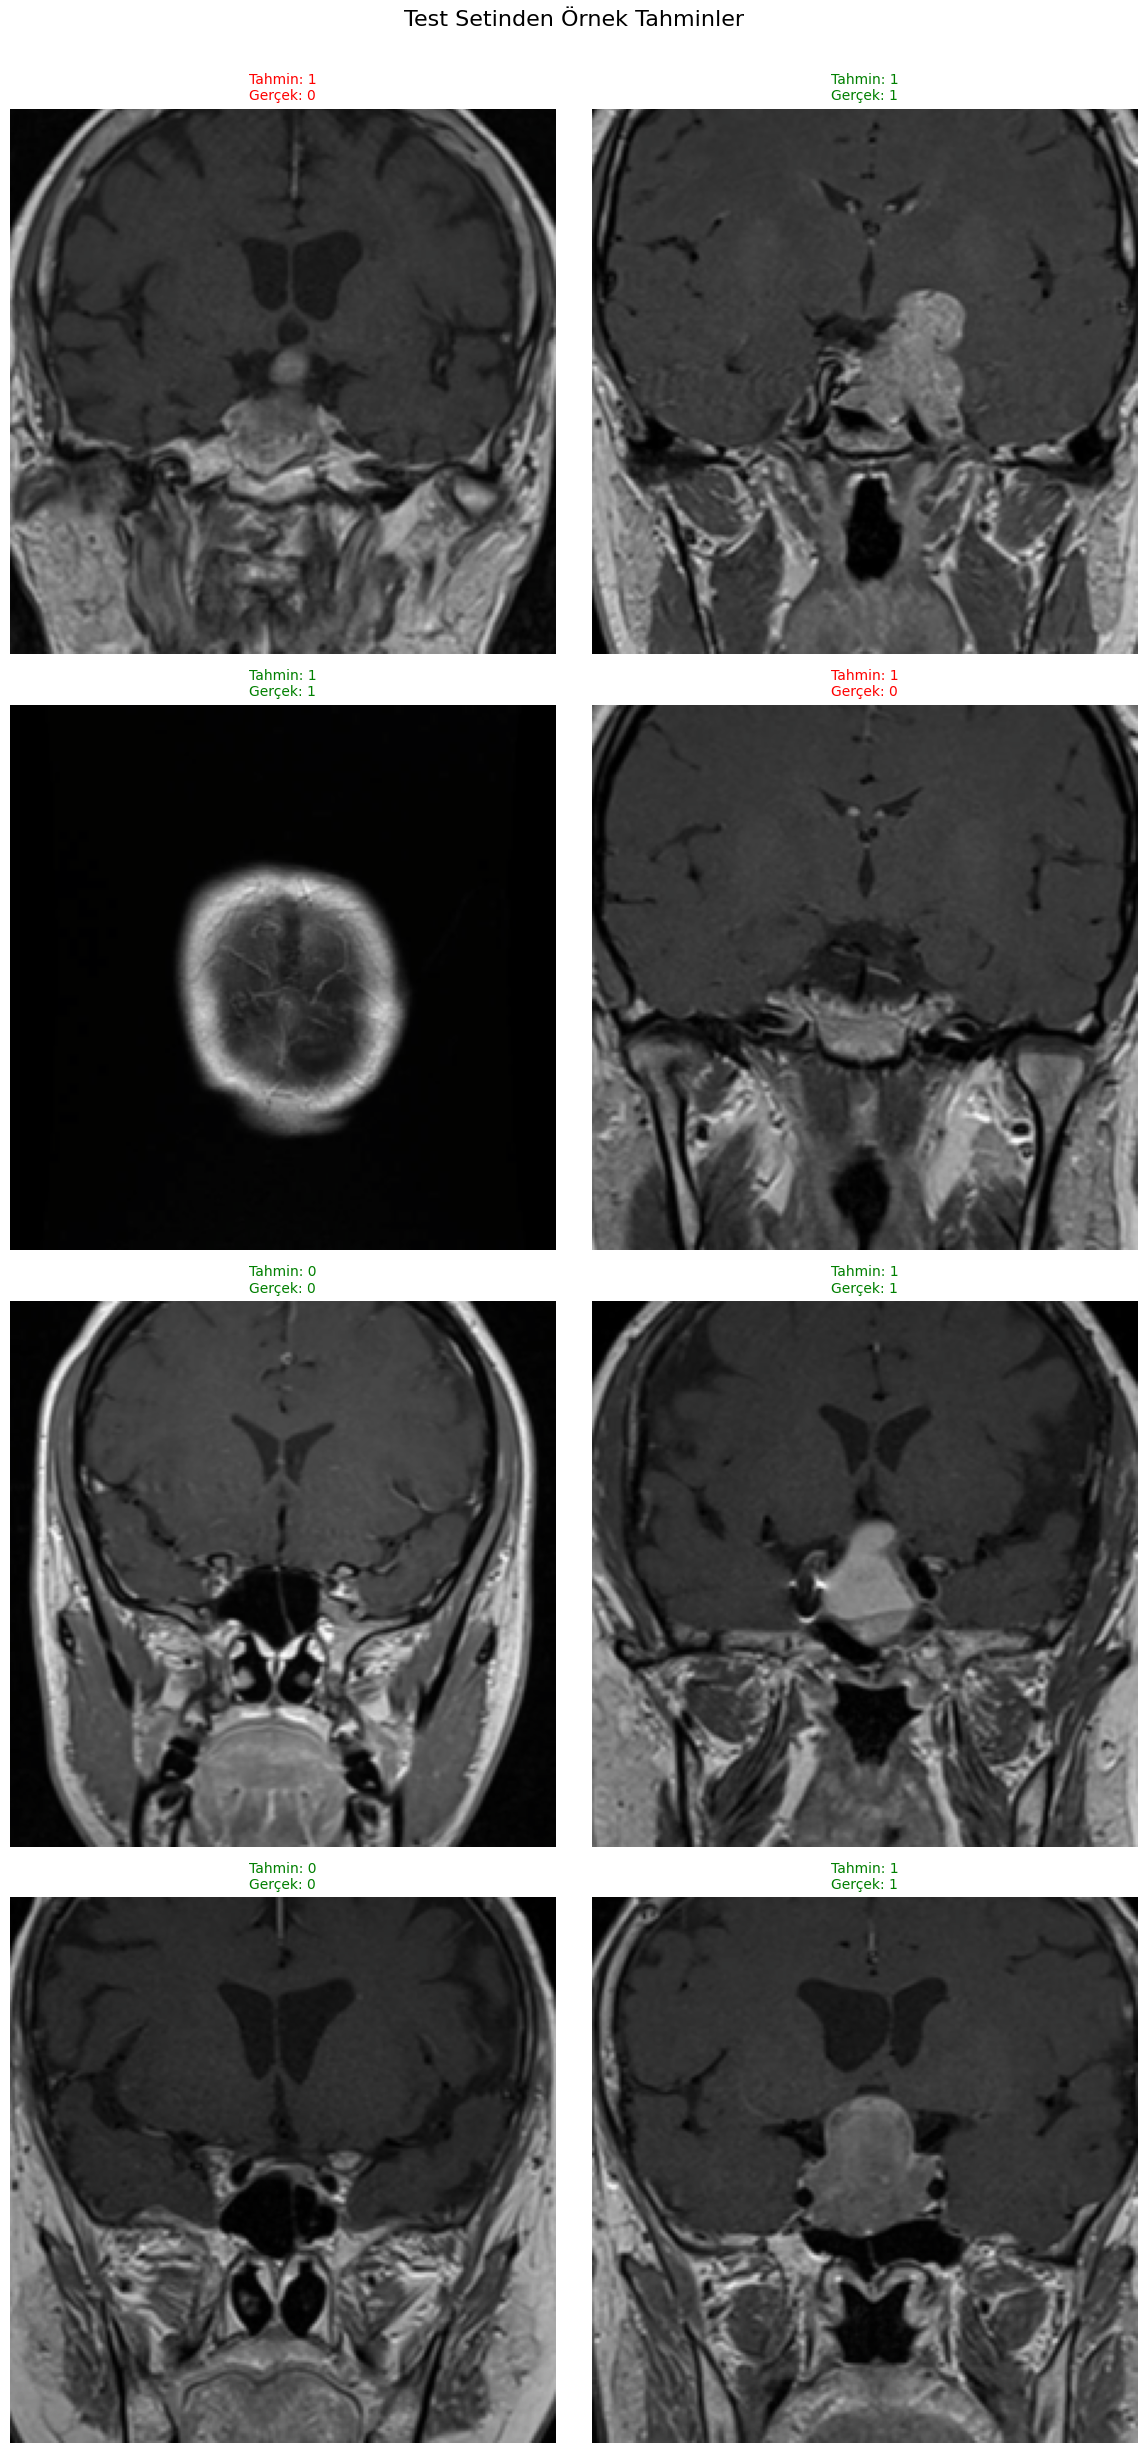

In [11]:
def visualize_model_predictions(model, dataloader_vis, num_images=8, phase_name="Doğrulama"):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    actual_num_images = min(num_images, dataset_sizes[phase_name.lower()]) # Dataloader'daki resim sayısını geçme
    if actual_num_images == 0:
        print(f"{phase_name} veri yükleyicisinde hiç resim yok.")
        return

    rows = (actual_num_images + 1) // 2 # En fazla 2 sütun olacak şekilde satır sayısını ayarla
    fig = plt.figure(figsize=(12, rows * 6)) # Figür boyutunu ayarla

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_vis):
            inputs_vis = inputs.to(device) # Görselleştirme için ayrı bir değişken
            labels_vis = labels.to(device)

            outputs = model(inputs_vis)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs_vis.size()[0]):
                images_so_far += 1
                ax = plt.subplot(rows, 2, images_so_far)
                ax.axis('off')
                prediction_correct = preds[j] == labels_vis[j]
                title_color = "green" if prediction_correct else "red"
                ax.set_title(f'Tahmin: {class_names[preds[j]]}\nGerçek: {class_names[labels_vis[j]]}',
                             color=title_color, fontsize=10)
                
                # Orijinal (normalize edilmemiş) görüntüyü göstermek için imshow fonksiyonunu kullan
                # inputs[j] tensörünü CPU'ya alıp numpy'a çevir
                img_to_show = inputs[j].cpu()
                imshow(img_to_show) # imshow fonksiyonu daha önce tanımlanmış olmalı (Hücre 3'te)

                if images_so_far == actual_num_images:
                    model.train(mode=was_training) # Modeli orijinal durumuna geri döndür
                    plt.tight_layout()
                    plt.suptitle(f"{phase_name} Setinden Örnek Tahminler", fontsize=16, y=1.02)
                    plt.show()
                    return
        
        model.train(mode=was_training) # Eğer döngü biterse de modeli eski haline getir
    
    if images_so_far > 0 : # Eğer en az bir resim gösterildiyse
        plt.tight_layout()
        plt.suptitle(f"{phase_name} Setinden Örnek Tahminler", fontsize=16, y=1.02)
        plt.show()
    else:
        print(f"{phase_name} veri yükleyicisinden görselleştirilecek resim bulunamadı.")


# Doğrulama setinden bazı tahminleri görselleştir
print("\nDoğrulama Setinden Örnek Tahminler:")
visualize_model_predictions(model_trained, dataloaders['val'], num_images=8, phase_name="Val")

# Test setinden bazı tahminleri görselleştir
print("\nTest Setinden Örnek Tahminler:")
visualize_model_predictions(model_trained, dataloaders['test'], num_images=8, phase_name="Test")


Test Seti için AUC Skoru: 0.9187


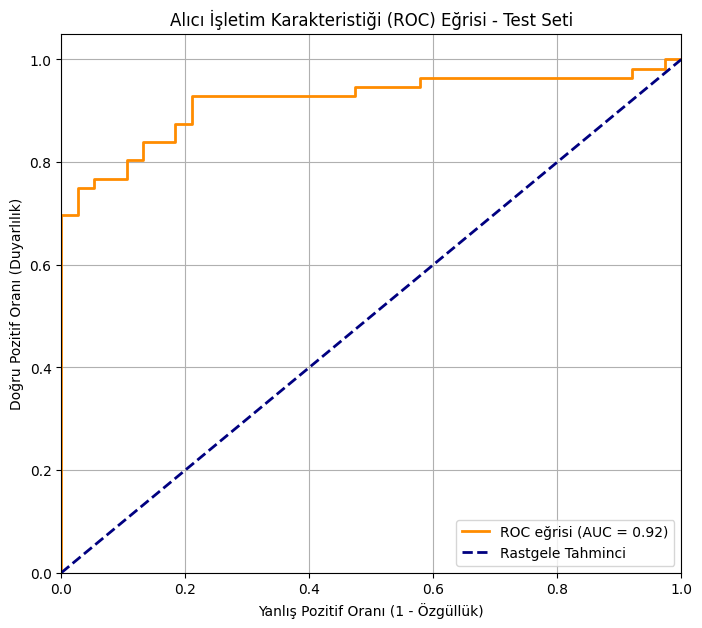

Youden's J istatistiğine göre en iyi eşik değeri: 0.9479
Bu eşikte TPR: 0.7500, FPR: 0.0263


In [12]:
import torch
import torch.nn.functional as F # Softmax için
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def get_probabilities_and_labels(model, dataloader, device):
    """
    Verilen model ve dataloader kullanarak gerçek etiketleri ve
    pozitif sınıf için tahmin edilen olasılıkları döndürür.
    """
    model.eval()  # Değerlendirme modu
    all_labels = []
    all_probs_positive_class = [] # Pozitif sınıf için olasılıklar (genellikle sınıf '1')

    with torch.no_grad(): # Gradyan hesaplamasını kapat
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Etiketleri CPU'da ve numpy array olarak tutalım
            all_labels.extend(labels.cpu().numpy())

            outputs = model(inputs) # Modelden ham logit'leri al
            
            # Logit'leri olasılıklara çevir (Softmax kullanarak)
            probabilities = F.softmax(outputs, dim=1)
            
            # Pozitif sınıfın olasılıklarını al (varsayım: sınıf '1' pozitif ve indeksi 1)
            # Eğer class_names = ['0', '1'] ise, pozitif sınıf '1' in indeksi 1'dir.
            # Emin olmak için class_names'e göre pozitif sınıfın indeksini bulunabiliriz:
            try:
                positive_class_index = class_names.index('1') # Veya sizin pozitif sınıf etiketiniz
            except ValueError:
                print("Uyarı: '1' sınıfı class_names içinde bulunamadı. Pozitif sınıf indeksi olarak 1 varsayılıyor.")
                positive_class_index = 1 # Varsayılan

            probs_positive = probabilities[:, positive_class_index].cpu().numpy()
            all_probs_positive_class.extend(probs_positive)
            
    return np.array(all_labels), np.array(all_probs_positive_class)

# Test seti üzerinde etiketleri ve olasılıkları al
y_true_test, y_pred_probs_test = get_probabilities_and_labels(model_trained, dataloaders['test'], device)

# Pozitif sınıfın etiketini belirle (genellikle 1)
# Eğer ImageFolder etiketleri 0 ve 1 olarak atadıysa ve '1' pozitifse:
# roc_curve fonksiyonu, y_true'daki pozitif sınıfın etiketini `pos_label` ile bekler.
# Eğer y_true zaten 0 ve 1'lerden oluşuyorsa ve 1 pozitifse, pos_label=1 olmalı.
# Bizim y_true_test'imiz zaten 0 ve 1'lerden oluşuyor.
positive_label_value = 1 # Sınıf '1' i pozitif kabul ediyoruz

# ROC eğrisi için FPR, TPR ve eşik değerlerini hesapla
# roc_curve, y_true'nun ikili olmasını bekler ve y_score'un pozitif sınıfa ait olasılıklar olmasını bekler.
fpr, tpr, thresholds = roc_curve(y_true_test, y_pred_probs_test, pos_label=positive_label_value)

# AUC skorunu hesapla
roc_auc = auc(fpr, tpr)
# Alternatif olarak: roc_auc = roc_auc_score(y_true_test, y_pred_probs_test)
# Eğer çok sınıflı bir durum olsaydı ve OvR (One-vs-Rest) yapmak isteseydik:
# roc_auc = roc_auc_score(y_true_test, probabilities_all_classes, multi_class='ovr', average='macro')

print(f"\nTest Seti için AUC Skoru: {roc_auc:.4f}")

# ROC Eğrisini Çizdir
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Tahminci')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (1 - Özgüllük)')
plt.ylabel('Doğru Pozitif Oranı (Duyarlılık)')
plt.title('Alıcı İşletim Karakteristiği (ROC) Eğrisi - Test Seti')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# İsteğe bağlı: En iyi eşik değerini bulmak için bir yöntem
# (Youden's J statistic veya TPR ve FPR arasındaki mesafeyi minimuma indirme gibi)
# Bu, ROC eğrisinden bir çalışma noktası seçmek için kullanılabilir.
# Örneğin, Youden's J:
if len(thresholds) > 0 and len(tpr) > 0 and len(fpr) > 0:
    J = tpr - fpr
    try:
        ix = np.argmax(J)
        if ix < len(thresholds): # threshold'ların sayısı tpr/fpr'dan bir eksik olabilir
            best_thresh_youden = thresholds[ix]
            print(f"Youden's J istatistiğine göre en iyi eşik değeri: {best_thresh_youden:.4f}")
            print(f"Bu eşikte TPR: {tpr[ix]:.4f}, FPR: {fpr[ix]:.4f}")
        else: # threshold sayısı tpr/fpr sayısıyla aynıysa (bazı roc_curve implementasyonlarında)
            if ix < len(thresholds):
                 best_thresh_youden = thresholds[ix]
                 print(f"Youden's J istatistiğine göre en iyi eşik değeri: {best_thresh_youden:.4f}")
                 print(f"Bu eşikte TPR: {tpr[ix]:.4f}, FPR: {fpr[ix]:.4f}")
            else: # Nadir durum, index eşleşmiyor
                print("Uyarı: Youden's J için eşik değeri indeksi bulunamadı.")

    except ValueError as e:
        print(f"En iyi eşik değeri hesaplanırken hata (ValueError): {e}")
    except IndexError as e:
        print(f"En iyi eşik değeri hesaplanırken hata (IndexError): {e}")

else:
    print("Uyarı: ROC eğrisi verileri (thresholds, tpr, fpr) boş veya yetersiz.")